A notebook for fitting models to one example system at a time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import random

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import torch

from janelia_core.math.basic_functions import list_grid_pts
from janelia_core.math.basic_functions import pts_in_arc
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.fitting import match_torch_module
from janelia_core.ml.torch_distributions import MatrixGammaProductDistribution
from janelia_core.stats.regression import corr

from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import fit_with_hypercube_priors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_regression import load_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_regression import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import predict
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection
from probabilistic_model_synthesis.simulation import generate_sum_of_bump_fcns_dist
from probabilistic_model_synthesis.simulation import efficient_cone_and_projected_interval_sample
from probabilistic_model_synthesis.simulation import IncreasingSinFcn
from probabilistic_model_synthesis.utilities import print_heading
from probabilistic_model_synthesis.utilities import print_info


## Parameters go here 

In [3]:
ps = dict()

# Range of the number of input variables we observe from each example system - the actual number of variables we
# observe from an example system will be pulled uniformly from this range (inclusive)
ps['n_input_var_range'] = [10000, 11000]

# Range of the number of samples we observe from each example system - the actual number we observe from each
# example system will be unformly from this range (inclusive)
ps['n_smps_range'] = [100000, 100001] #[15000, 15001] works

# Number of intermediate variables we project down into
ps['p'] = 1

# Number of variabales we predict
ps['d_pred'] = 1


# ===============================================================================================
# Parameters for the true priors

# Options for the prior distribution on weights
ps['true_w_prior_opts'] = {'n_bump_fcns': 50, 'd_in': 2, 'p': 1, 'mn_m_std': 1.0, 'std_m_std': .1, 'bump_w': .2}

# Options for the prior on noise standard deviations
ps['true_psi_prior_opts'] = {'conc_iv': 10.0, 'rate_iv': 1000.0, 'rate_ub': 10000.0}

# ===============================================================================================
# Options for fixed scales and offsets (we don't learn these)

# Scales and offsets to apply when projecting down to the intermediate variables
ps['s_in'] = torch.tensor([1.0 / np.sqrt(ps['n_input_var_range'][0])] * ps['p'], dtype=torch.float)
ps['b_in'] = torch.tensor([0.0] * ps['p'], dtype=torch.float)

# Scales and offsets to apply after the m-module
ps['s_out'] = torch.tensor([1.0] * ps['d_pred'], dtype=torch.float)
ps['b_out'] = torch.tensor([0.0] * ps['d_pred'], dtype=torch.float)

# ===============================================================================================
# Parameters for setting up how we fit things with DPMS

# The full options for setting up the prior on weights
fit_hc_params = {'n_divisions_per_dim': [1, 1],
                 'dim_ranges': np.asarray([[-.1, 1.1],
                                           [-.1, 1.1]]),
                 'n_div_per_hc_side_per_dim': [2, 2]}

# The full options for setting up the prior on weights
ps['fit_w_prior_opts'] = {'mn_hc_params': fit_hc_params, 'std_hc_params': fit_hc_params,
                          'min_std': 1E-9, 'mn_init': 0.0, 'std_init': 300}

# Options for prior on noise standard deviation
ps['fit_psi_prior_opts'] = ps['true_psi_prior_opts']

# Options for posterior distribtions
ps['psi_post_opts'] = {'conc_iv': 10.0, 'rate_iv': 1.0, 'rate_ub': 100000.0}

# Options for the densenet which makes up the shared-m module
ps['dense_net_opts'] = {'n_layers': 2, 'growth_rate': 10, 'bias': True}


# ======================================================================================================
# Parameters for fitting - should be entered as lists, each entry corresponding to one round of fitting

# Parameters when fitting combined models

cp_save_folder = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/testing/gnlr'
cp_save_folder = pathlib.Path(cp_save_folder) / 'cp'

ps['sp_fit_opts'] = [{'n_epochs': 10, 'milestones': None, 'update_int': 100, 
                      'init_lr': .0, 'n_batches': 2, 
                      'cp_save_folder': cp_save_folder, 'cp_save_str': 'sp_', 
                      'cp_epochs': list(range(0, 1000, 100)) + [9999]}]
ps['ip_fit_opts'] = [{'n_epochs': 1000, 'milestones': [5000], 'update_int': 100, 
                      'init_lr': .001, 'n_batches': 2, 
                      'cp_save_folder': cp_save_folder, 'cp_save_str': 'ip_', 
                      'cp_epochs': list(range(0, 1000, 100)) + [9999]},
                     {'n_epochs': 1000, 'milestones': [1000], 'update_int': 100, 
                      'init_lr': .001, 'n_batches': 2, 
                      'cp_save_folder': cp_save_folder, 'cp_save_str': 'ip_', 
                      'cp_epochs': list(range(0, 1000, 100)) + [9999]}]

# ======================================================================================================
# Determine if we set a random seed.  Can use this for reproducibility.

ps['random_seed'] = None # Set to None, to not set random seeds


# ======================================================================================================
# Specify the range of active neurons
ps['ang_range'] = [0, np.pi] # [0, np.pi]

# ======================================================================================================
# Specify interval data is generated in 
ps['int_range'] = [-196.0, -98.0]

## Set random seeds for reprodicability of results

In [4]:
if ps['random_seed'] is not None:
    torch.manual_seed(ps['random_seed'])
    random.seed(ps['random_seed'])
    np.random.seed(ps['random_seed'])

## Create true distributions that govern how true systems are generated

In [5]:
true_priors = PriorCollection(w_prior=generate_sum_of_bump_fcns_dist(**ps['true_w_prior_opts']),
                              psi_prior=MatrixGammaProductDistribution(shape=[ps['d_pred'], 1],
                                                                       **ps['true_psi_prior_opts']))

## Define the true non-linear function relating projections of input variables to the mean of output variables

In [6]:
m_true = IncreasingSinFcn()

In [7]:
class Identity(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [8]:
#m_true = Identity()

## Generate example system and data

Generate example properties 

In [9]:
ind_n_vars = np.random.randint(ps['n_input_var_range'][0], ps['n_input_var_range'][1]+1)
ind_props = torch.rand(size=[ind_n_vars,2])

Generate true model

In [10]:
true_mdl = GNLRMdl(m=m_true,
                   w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(ind_props)),
                   s_in=ps['s_in'],
                   b_in=ps['b_in'],
                   s_out=ps['s_out'],
                   b_out=ps['b_out'],
                   psi=true_priors.psi_prior.form_standard_sample(
                       true_priors.psi_prior.sample(ind_props)).squeeze(axis=1))

Generate data from the example system

In [11]:
ind_n_smps = np.random.randint(ps['n_smps_range'][0], ps['n_smps_range'][1])

In [12]:
x_train = efficient_cone_and_projected_interval_sample(n_smps=ind_n_smps,
                                                       locs=ind_props,
                                                       ctr=torch.tensor([.5, .5]),
                                                       ang_range=ps['ang_range'],
                                                       w=true_mdl.w.detach(),
                                                       interval=ps['int_range'],
                                                       big_std=1.0,
                                                       small_std=0,
                                                       device=torch.device('cuda'))

In [13]:
true_mdl.to('cuda')
with torch.no_grad():
        y_train = true_mdl.sample(x=x_train)

## Fit model to the example system with DPMS

In [14]:
fit_rs = fit_with_hypercube_priors(data=[(x_train, y_train)],
                                   props=[ind_props], 
                                   p=ps['p'],
                                   dense_net_opts=ps['dense_net_opts'],
                                   sp_fit_opts=ps['sp_fit_opts'],
                                   ip_fit_opts=ps['ip_fit_opts'],
                                   w_prior_opts=ps['fit_w_prior_opts'],
                                   psi_prior_opts=ps['fit_psi_prior_opts'],
                                   psi_post_opts=ps['psi_post_opts'],
                                   sp_fixed_var=True,
                                   fixed_s_in_vl=ps['s_in'],
                                   fixed_b_in_vl=ps['b_in'],
                                   fixed_s_out_vl=ps['s_out'],
                                   fixed_b_out_vl=ps['b_out'], 
                                   match_init_ip_w_post_to_prior=False)

fixed_s_in: True
Found 1 GPUs
Fixing variance of sp w_prior.
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 1.17e+07
----------------------------------------
NELL: 1.17e+07
W KL: 0.00e+00
S_in KL: 0.00e+00
B_in KL: 0.00e+00
S_out KL: 0.00e+00
B_out KL: 0.00e+00
Psi KL: 9.93e+03
----------------------------------------
LR: 0.0
Elapsed time (secs): 0.0349428653717041
----------------------------------------
CPU cur memory used (GB): 4.58e+00
GPU_0 cur memory used (GB): 4.07e+00, max memory used (GB): 4.07e+00
Saved check point for epoch 0.
Beginning IP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 3.19e+05
----------------------------------------
NELL: 2.02e+05
W KL: 1.07e+05
S_in KL: 0.00e+00
B_in KL: 0.00e+00
S_out KL: 0.00e+00
B_out KL: 0.00e+00
Psi KL: 9.89e+03
----------------------------------------
LR: 0.001
Elapsed time (secs): 0.04531049728393555
----------------------------------------
CPU cur memory used (GB): 8.65e+00
GPU_0 cur memory used (GB)


=========== EPOCH 600 COMPLETE ===========
Obj: -4.35e+04
----------------------------------------
NELL: -5.98e+04
W KL: 1.62e+04
S_in KL: 0.00e+00
B_in KL: 0.00e+00
S_out KL: 0.00e+00
B_out KL: 0.00e+00
Psi KL: 2.52e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 27.223101377487183
----------------------------------------
CPU cur memory used (GB): 8.65e+00
GPU_0 cur memory used (GB): 4.07e+00, max memory used (GB): 4.07e+00
Saved check point for epoch 600.

=========== EPOCH 700 COMPLETE ===========
Obj: -3.87e+04
----------------------------------------
NELL: -5.53e+04
W KL: 1.67e+04
S_in KL: 0.00e+00
B_in KL: 0.00e+00
S_out KL: 0.00e+00
B_out KL: 0.00e+00
Psi KL: 2.00e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 31.746363401412964
----------------------------------------
CPU cur memory used (GB): 8.65e+00
GPU_0 cur memory used (GB): 4.07e+00, max memory used (GB): 4.07e+00
Saved check point for epoch 700.

=========== EPOCH

## Visualize where active neurons are

In [15]:
neuron_train_vars = torch.var(x_train, dim=0).cpu().numpy()

Text(0.5, 1.0, 'Variance of individual neurons in training data')

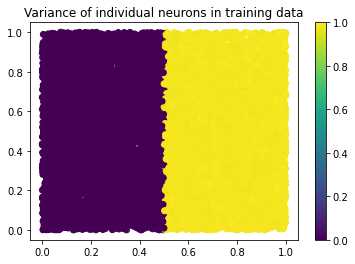

In [16]:
active_clrs = cm.viridis((neuron_train_vars - np.min(neuron_train_vars))/
                         (np.max(neuron_train_vars) - np.min(neuron_train_vars)))
plt.figure()
plt.scatter(ind_props[:,0].numpy(), ind_props[:,1].numpy(), color=active_clrs)
plt.colorbar() 
plt.title('Variance of individual neurons in training data')

## Visualize the range of the low-d space explored in the training data 

Text(0.5, 1.0, 'Projected Training Data')

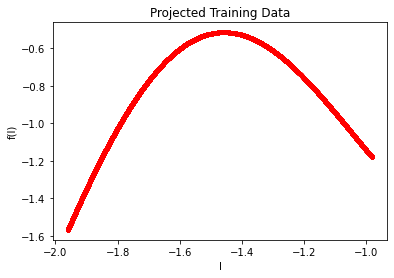

In [17]:
with torch.no_grad():
    l_train = true_mdl.project(x=x_train)
    f_train = true_mdl.m(l_train)
    l_train = l_train.cpu().numpy()
    f_train = f_train.cpu().numpy()
    
plt.figure()
plt.plot(l_train, f_train, 'r.')
plt.xlabel('l')
plt.ylabel('f(l)')
plt.title('Projected Training Data')

## Specify the type of fit results we want to example

In [18]:
fit_type = 'ip'

In [19]:
fit_vi_coll = fit_rs[fit_type]['vi_collections'][0]
fit_vi_coll.to('cuda')

## View fitting logs
(if we want to)

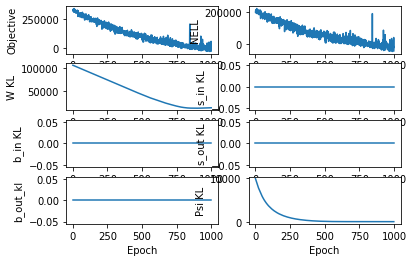

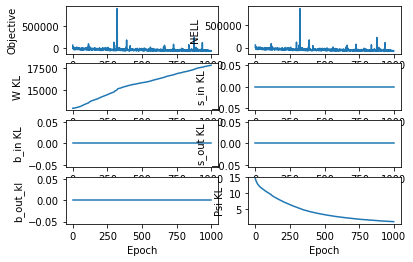

In [20]:
if True:
    for log in fit_rs[fit_type]['logs']:
        Fitter.plot_log(log)

## Look at predictions on training data 

Text(0, 0.5, 'y pred')

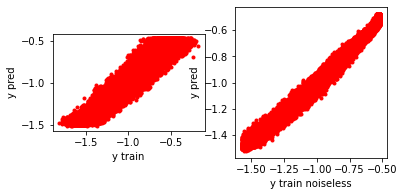

In [21]:
with torch.no_grad(): 
    y_train_plot = y_train.cpu().numpy()
    y_train_noiseless = true_mdl(x_train).cpu().numpy()
    y_train_pred = predict(coll=fit_vi_coll, x=x_train).cpu().numpy()    

plt.figure()

ax = plt.subplot(1,2,1)
plt.plot(y_train_plot, y_train_pred, 'r.')
ax.set_aspect('equal')
plt.xlabel('y train')
plt.ylabel('y pred')

ax = plt.subplot(1,2,2)
plt.plot(y_train_noiseless, y_train_pred, 'r.')
ax.set_aspect('equal')
plt.xlabel('y train noiseless')
plt.ylabel('y pred')

## Visualize the mean and standard deviation of the true CPD 

In [22]:
# Helper formatting function
def format_box(ax):
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.xlabel('property dim 1 (a.u.)')
    plt.ylabel('property dim 2 (a.u.)')

Text(0.5, 1.0, 'True CPD Standard Deviation')

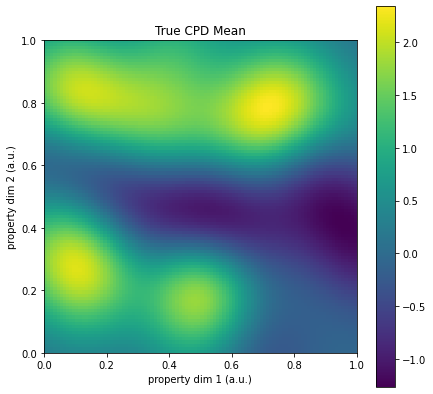

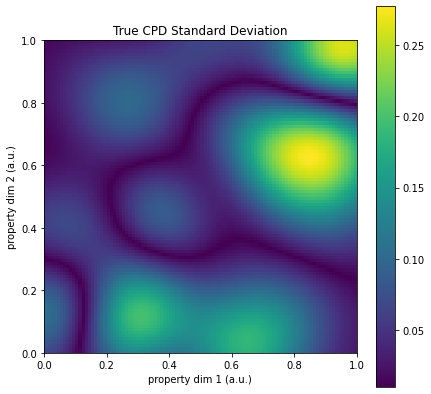

In [23]:
pts, dim_pts = list_grid_pts(grid_limits=np.asarray([[0, 1.0], [0, 1.0]]), n_pts_per_dim=[100,100])
pts = torch.tensor(pts, dtype=torch.float)

true_w_mn = true_priors.w_prior(pts).detach().numpy()
true_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in true_priors.w_prior.dists], axis=1)
true_w_mn_im = true_w_mn.reshape([100,100]).transpose()
true_w_std_im = true_w_std.reshape([100,100]).transpose()

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_mn_im, origin='lower', extent=[0, 1.0, 0, 1.0])
mn_vmin, mn_vmax = im.get_clim() # Keep track of color limits
plt.colorbar(im)
format_box(ax)
plt.title('True CPD Mean')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_std_im, origin='lower', extent=[0, 1.0, 0, 1.0])
std_vmin, std_vmax = im.get_clim() # Keep track of color limits
plt.colorbar(im)
format_box(ax)
plt.title('True CPD Standard Deviation')

## Visualize the mean and standard deviation of the fit CPD 

In [24]:
# Helper function for corresponding fit and true CPDs
def get_fit_to_true_cpd_scale(fit_priors, true_priors, ang_range=None):
    """
    Learns the best scale to match the fit CPD to the true CPD. 
    
    """
  
    sc_grid_pts, _ = list_grid_pts(grid_limits=np.asarray([[0, 1.0], [0, 1.0]]), n_pts_per_dim=[100,100])
    sc_grid_pts = torch.tensor(sc_grid_pts[pts_in_arc(sc_grid_pts, np.asarray([.5, .5]), ang_range),:])

    return  np.linalg.lstsq(fit_priors.w_prior(sc_grid_pts).detach().numpy(),
                            true_priors.w_prior(sc_grid_pts).detach().numpy(), rcond=None)[0].item()


In [25]:
fit_priors = fit_rs['ip']['priors']

fit_w_mn = fit_priors.w_prior(pts).detach().numpy()
fit_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in fit_priors.w_prior.dists], axis=1)

Learn the best scale to match the fit CPD to the true CPD - we use the portion of space only where it should be possible to learn the CPD for this.  This should produce the best correspondance between the true and fit CPD for models when we apply DPMS to subjects in isolation.  Because we want to show that using DPMS with many subjects is better than fitting to subjects individually, this produces a conservative visualization for the purposes of our comparison. 

In [26]:
# Angle range is only used for single fits
true_to_fit_cpd_sc = get_fit_to_true_cpd_scale(fit_priors, true_priors, ang_range=ps['ang_range'])

In [46]:
true_to_fit_cpd_sc

1.9841501385631215

In [27]:
fit_w_mn_scaled = fit_w_mn*true_to_fit_cpd_sc
fit_w_std_scaled = fit_w_std*np.abs(true_to_fit_cpd_sc)

fit_w_mn_scaled_im = fit_w_mn_scaled.reshape([100,100]).transpose()
fit_w_std_scaled_im = fit_w_std_scaled.reshape([100,100]).transpose()

Text(0.5, 1.0, 'Fit CPD Standard Deviation')

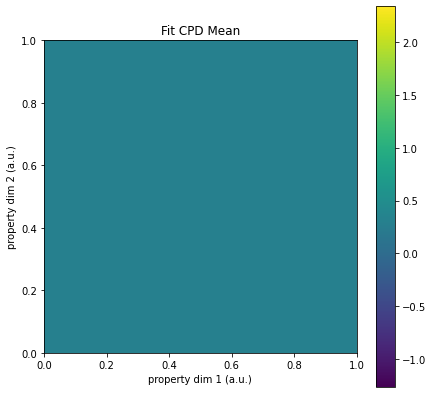

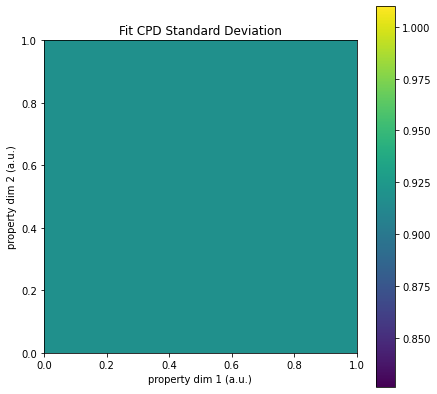

In [28]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(fit_w_mn_scaled_im, origin='lower', extent=[0, 1.0, 0, 1.0], vmin=mn_vmin, vmax=mn_vmax)
plt.colorbar(im)
format_box(ax)
plt.title('Fit CPD Mean')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(fit_w_std_scaled_im, origin='lower', extent=[0, 1.0, 0, 1.0])#, vmin=std_vmin, vmax=std_vmax)
plt.colorbar(im)
format_box(ax)
plt.title('Fit CPD Standard Deviation')

## Visualize the true and fit shared function 

First we have to scale and offset the fit function to best match the true function

In [29]:
min_l_range = ps['int_range'][0]*ps['s_in']
max_l_range = ps['int_range'][1]*ps['s_in']

l_plot_pts = np.linspace(min_l_range,max_l_range,1000)
m_true_pts = m_true(torch.tensor(l_plot_pts)).numpy()

In [30]:
m_fit_range = (torch.tensor(ps['int_range'], dtype=torch.float32)*ps['s_in']).unsqueeze(1)

In [31]:
# Initialization options we search over
weight_vls = np.linspace(-10, 10, 10)
bias_vls = np.linspace(-10, 10, 10)
er_vls = np.zeros([len(weight_vls), len(bias_vls)])

best_er = np.inf
best_inds = (None, None)
for w_i, w_v in enumerate(weight_vls):
    for b_i, b_v in enumerate(bias_vls):
        m_fit = copy.deepcopy(fit_rs[fit_type]['vi_collections'][0].mdl.m)
        for param in m_fit.parameters():
            param.requires_grad = False
        m_fit_scaled = torch.nn.Sequential(torch.nn.Linear(1, 1, bias=True), m_fit)
        m_fit_scaled[0].weight.data[0] = w_v
        m_fit_scaled[0].bias.data[0] = b_v

        er = match_torch_module(m_true, m_fit_scaled, m_fit_range, 
                                optim_opts={'lr': .001}, n_its=500, update_int=6000)
        
        er = er.detach().numpy()
        if er < best_er:
            best_er = er
            best_inds = (w_i, b_i)
            print(best_er)
   

17541.898
5855.721
3346.7344
2686.4302
735.0435
210.08374
59.25741
35.489025


In [32]:
m_fit_scaled = torch.nn.Sequential(torch.nn.Linear(1, 1, bias=True), m_fit)
m_fit_scaled[0].weight.data[0] = weight_vls[best_inds[0]]
m_fit_scaled[0].bias.data[0] = bias_vls[best_inds[1]]
match_torch_module(m_true, m_fit_scaled, m_fit_range, 
                   optim_opts={'lr': .001}, n_its=20000, update_int=5000)

It: 0, Error: 7.652267e+01
It: 5000, Error: 3.891726e-02
It: 10000, Error: 5.304184e-02
It: 15000, Error: 3.986827e-02


tensor(0.0396, grad_fn=<SumBackward0>)

Visualize true and fit m function 

In [33]:
m_fit_pts = m_fit_scaled(torch.tensor(l_plot_pts)).detach().numpy()

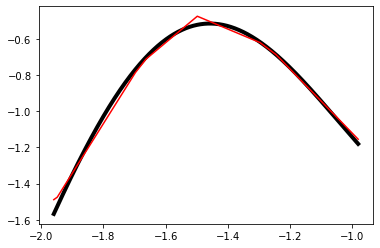

In [34]:
plt.figure()
plt.plot(l_plot_pts, m_true_pts, 'k-', linewidth=4)
plt.plot(l_plot_pts, m_fit_pts, 'r-')

## Look at the learned posteriors over weights 

In [35]:
w_true = true_mdl.w.detach().cpu().numpy()

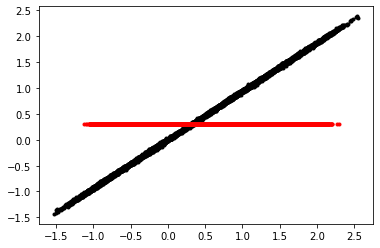

In [36]:
active_neurons = np.asarray((torch.var(x_train, dim=0) > 1E-10).tolist())
silent_neurons = ~active_neurons


post_mn_w = true_to_fit_cpd_sc*fit_rs[fit_type]['vi_collections'][0].posteriors.w_post(ind_props).detach().cpu().numpy()

plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(w_true[active_neurons], post_mn_w[active_neurons], 'k.')
plt.plot(w_true[silent_neurons], post_mn_w[silent_neurons], 'r.')
#plt.plot([-3, 3], [-3, 3], 'b--')
#ax.set_aspect('equal') 

## Look at true psi and learned posterior over psi

In [37]:
true_psi = true_mdl.psi.item()
fit_psi_mn = fit_vi_coll.posteriors.psi_post(None).item()
fit_psi_std = fit_vi_coll.posteriors.psi_post.dists[0].std(None).item()
print('True psi: ' + str(true_psi))
print('Fit psi mn: ' + str(fit_psi_mn) + ', std: ' + str(fit_psi_std))

True psi: 0.007587763015180826
Fit psi mn: 0.02659897692501545, std: 0.019552309066057205


## Evaluate model performance on novel data 

In [38]:
x_new =  efficient_cone_and_projected_interval_sample(n_smps=1000,
                                                      locs=ind_props,
                                                      ctr=torch.tensor([.5, .5]),
                                                      ang_range=ps['ang_range'],
                                                      w=true_mdl.w.detach(),
                                                      interval=ps['int_range'],
                                                      big_std=1.0,
                                                      small_std=0,
                                                      device=torch.device('cuda'))

In [39]:
with torch.no_grad():
    y_new_noiseless = true_mdl(x=x_new).cpu().numpy()
    y_new_pred = predict(coll=fit_vi_coll, x=x_new).cpu().numpy()  

Corr: [0.99338546]


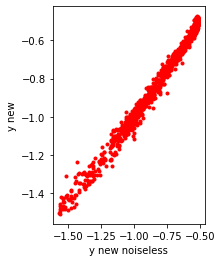

In [40]:
plt.figure()

ax = plt.subplot(1,2,1)
plt.plot(y_new_noiseless, y_new_pred, 'r.')
#ax.set_aspect('equal')
plt.xlabel('y new noiseless')
plt.ylabel('y new') 
print('Corr: ' + str(corr(y_new_noiseless, y_new_pred)))

## Examine performance across checkpoints 

In [41]:
sp_cps, sp_cp_epochs = load_check_points(cp_save_folder, 'cp_sp*')
ip_cps, ip_cp_epochs = load_check_points(cp_save_folder, 'cp_ip*')

Done loading check point 1 of 1.
Done loading check point 1 of 20.
Done loading check point 2 of 20.
Done loading check point 3 of 20.
Done loading check point 4 of 20.
Done loading check point 5 of 20.
Done loading check point 6 of 20.
Done loading check point 7 of 20.
Done loading check point 8 of 20.
Done loading check point 9 of 20.
Done loading check point 10 of 20.
Done loading check point 11 of 20.
Done loading check point 12 of 20.
Done loading check point 13 of 20.
Done loading check point 14 of 20.
Done loading check point 15 of 20.
Done loading check point 16 of 20.
Done loading check point 17 of 20.
Done loading check point 18 of 20.
Done loading check point 19 of 20.
Done loading check point 20 of 20.


### Look at distribution of projected training points 

In [42]:
eval_cp = ip_cps[-1]

cp_vi_coll = VICollection.from_checkpoint(eval_cp['vi_collections'][0])
cp_vi_coll.to('cuda')
cp_mdl = cp_vi_coll.mdl
cp_w_post = cp_vi_coll.posteriors.w_post


In [43]:
with torch.no_grad():
    l_true = true_mdl.project(x_train).detach().cpu().numpy()
    l_est = cp_mdl.project(x=x_train, w=cp_w_post(ind_props)).detach().cpu().numpy()

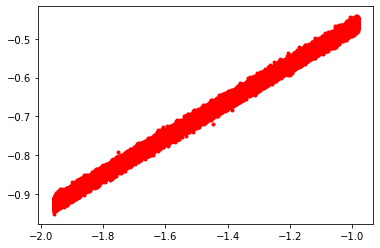

In [44]:
plt.figure()
plt.plot(l_true, l_est, 'r.')

In [45]:
sp_cps

[{'vi_collections': [{'mdl': GNLRMdl(
      (m): Sequential(
        (0): DenseLNLNet(
          (dense_lnl_0): DenseLayer(
            (m): Sequential(
              (0): Linear(in_features=1, out_features=10, bias=True)
              (1): ReLU()
            )
          )
          (dense_lnl_1): DenseLayer(
            (m): Sequential(
              (0): Linear(in_features=11, out_features=10, bias=True)
              (1): ReLU()
            )
          )
        )
        (1): Linear(in_features=21, out_features=1, bias=True)
      )
    ),
    'posteriors': {'w_post': CondMatrixHypercubePrior(
       (dists): ModuleList(
         (0): CondGaussianDistribution(
           (mn_f): SumOfTiledHyperCubeBasisFcns()
           (std_f): Sequential(
             (0): SumOfTiledHyperCubeBasisFcns()
             (1): FixedOffsetExp()
           )
         )
       )
     ),
     's_in_post': None,
     'b_in_post': None,
     's_out_post': None,
     'b_out_post': None,
     'psi_post': Matri